In [10]:
import sys
import os
from pathlib import Path

# Añadir el directorio raíz al path para poder importar src
# Asumiendo que el notebook está en notebooks/finales/
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

from src import config, data_loader, predictor

# Configuración de visualización
sns.set(style="whitegrid")
%matplotlib inline

## 1. Carga y Preparación de Datos

Cargamos los datos crudos y aplicamos el mismo pipeline de limpieza y encoding. Luego separamos el conjunto de test (20%) asegurando la reproducibilidad con la misma semilla aleatoria.

In [11]:
# Cargar y procesar datos
df = data_loader.load_raw_data()
df = data_loader.clean_data(df)
X, y = data_loader.encode_data(df)

# Split y escalado (obtenemos X_test y y_test)
X_train, X_test, y_train, y_test = data_loader.split_and_scale(X, y)

Cargando datos desde: C:\Users\PC\Documents\proyecto-final-ml\data\raw\dataset_practica_final.csv
Datos cargados. Shape inicial: (119390, 32)
Transformando variables categóricas...
Encoding completado. Features: 247
Dividiendo datos (Test size: 0.2)...
Escalando datos (StandardScaler)...
Datos listos para entrar al modelo.
   Train shape: (69916, 247)
   Test shape:  (17480, 247)


## 2. Carga del Modelo

Cargamos el modelo LightGBM que mostró el mejor desempeño en la fase de comparación.

In [12]:
model_path = config.MODELS_DIR / "boost_lightgbm.joblib"
print(f"Cargando modelo desde: {model_path}")
model = predictor.load(model_path)

Cargando modelo desde: C:\Users\PC\Documents\proyecto-final-ml\models\boost_lightgbm.joblib


c:\Users\PC\Documents\proyecto-final-ml\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 3. Generación de Predicciones

Generamos las predicciones de clase y las probabilidades para el conjunto de test.

In [13]:
y_pred = predictor.predict(model, X_test)
y_prob = predictor.predict_proba(model, X_test)[:, 1]

## 4. Métricas de Clasificación

Evaluamos el modelo utilizando Accuracy, Precision, Recall y F1-Score.

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8542334096109839

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     12675
           1       0.76      0.69      0.72      4805

    accuracy                           0.85     17480
   macro avg       0.82      0.80      0.81     17480
weighted avg       0.85      0.85      0.85     17480



## 5. Matriz de Confusión

Visualizamos los errores del modelo.

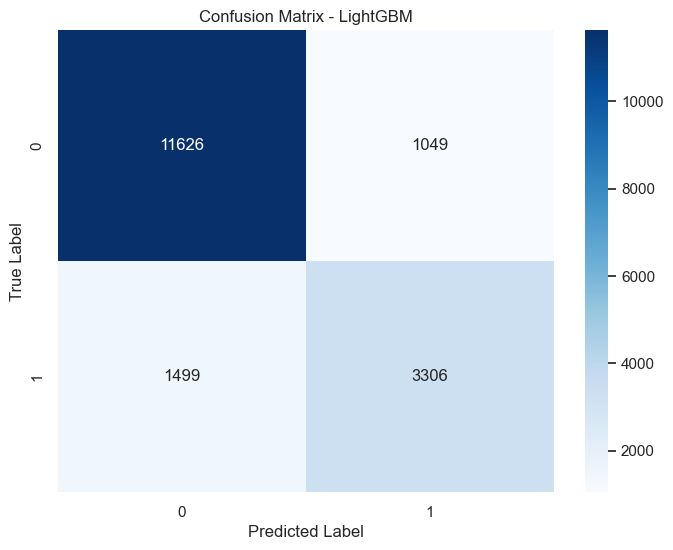

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Curva ROC y AUC

Analizamos la capacidad de discriminación del modelo.

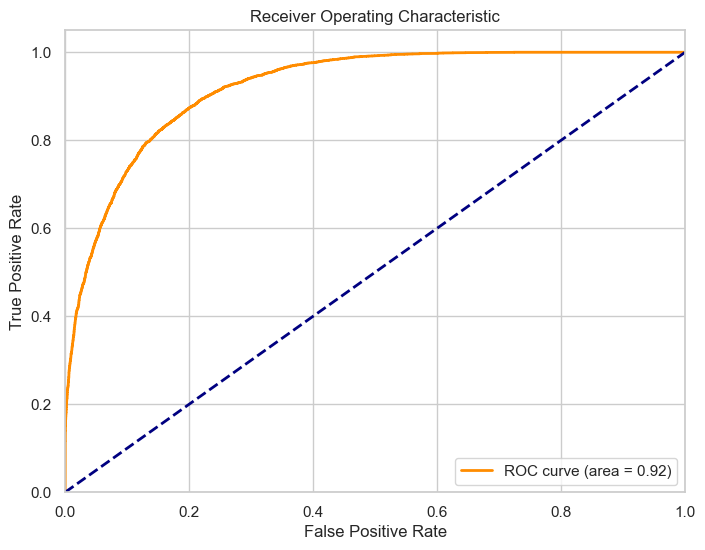

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 7. Importancia de Características

Identificamos qué variables influyen más en la predicción de cancelaciones.

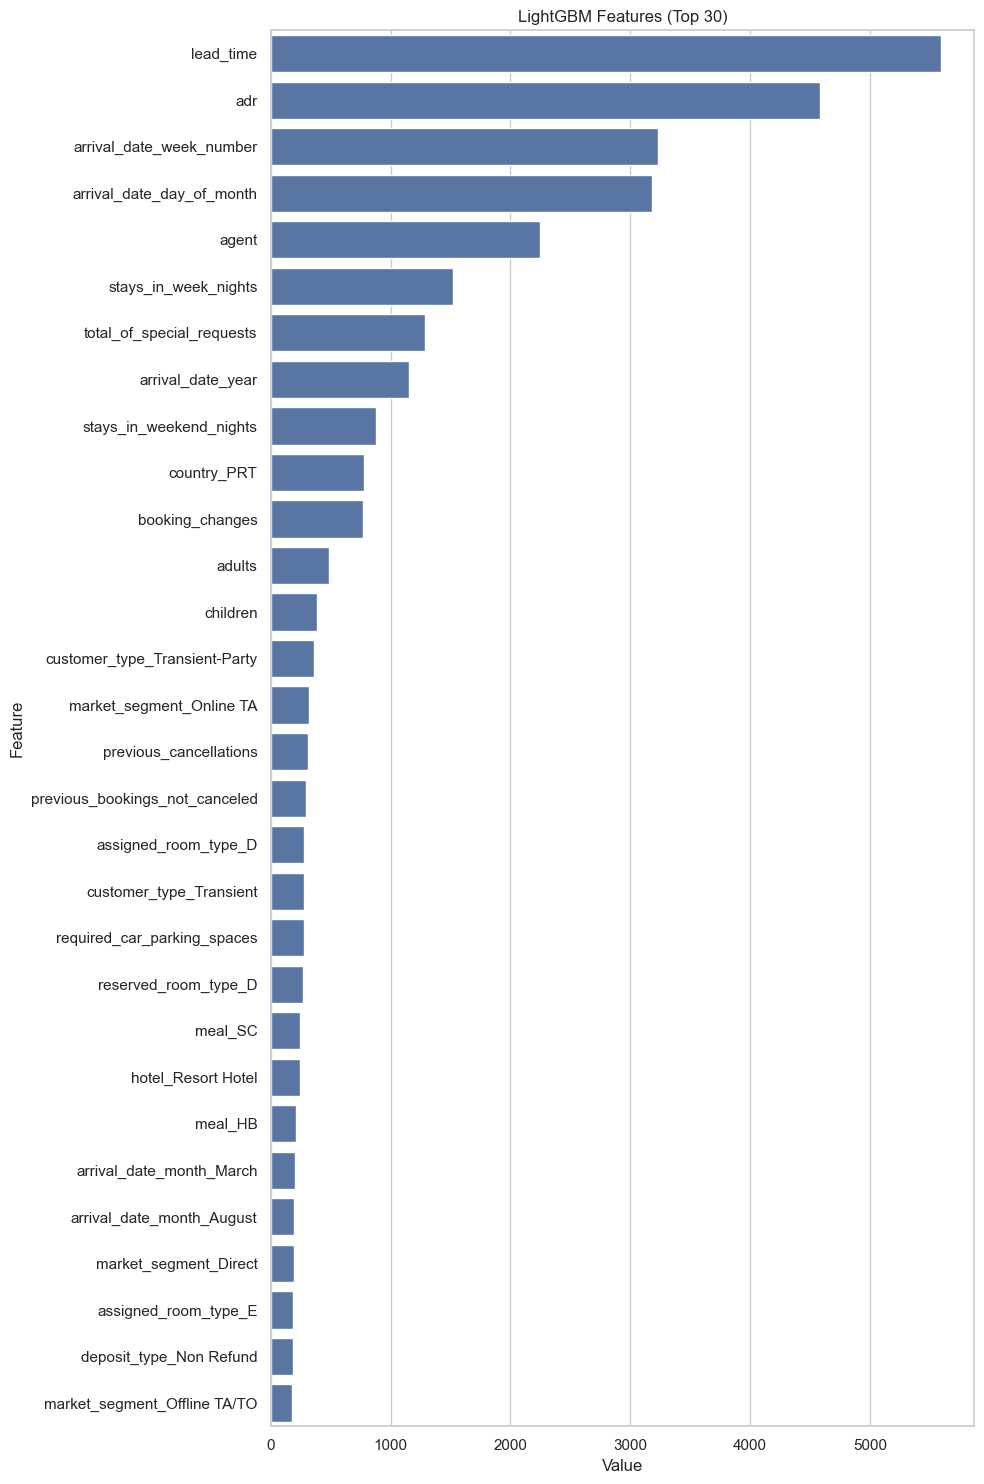

In [17]:
# LightGBM feature importance
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_test.columns
    feature_imp = pd.DataFrame(sorted(zip(importances, feature_names)), columns=['Value','Feature'])

    plt.figure(figsize=(10, 15))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
    plt.title('LightGBM Features (Top 30)')
    plt.tight_layout()
    plt.show()

## 8. Interpretabilidad Avanzada (SHAP)

Para entender mejor *por qué* el modelo toma ciertas decisiones, utilizamos SHAP (SHapley Additive exPlanations). Esto nos permite ver el impacto de cada característica en cada predicción individual.

c:\Users\PC\Documents\proyecto-final-ml\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


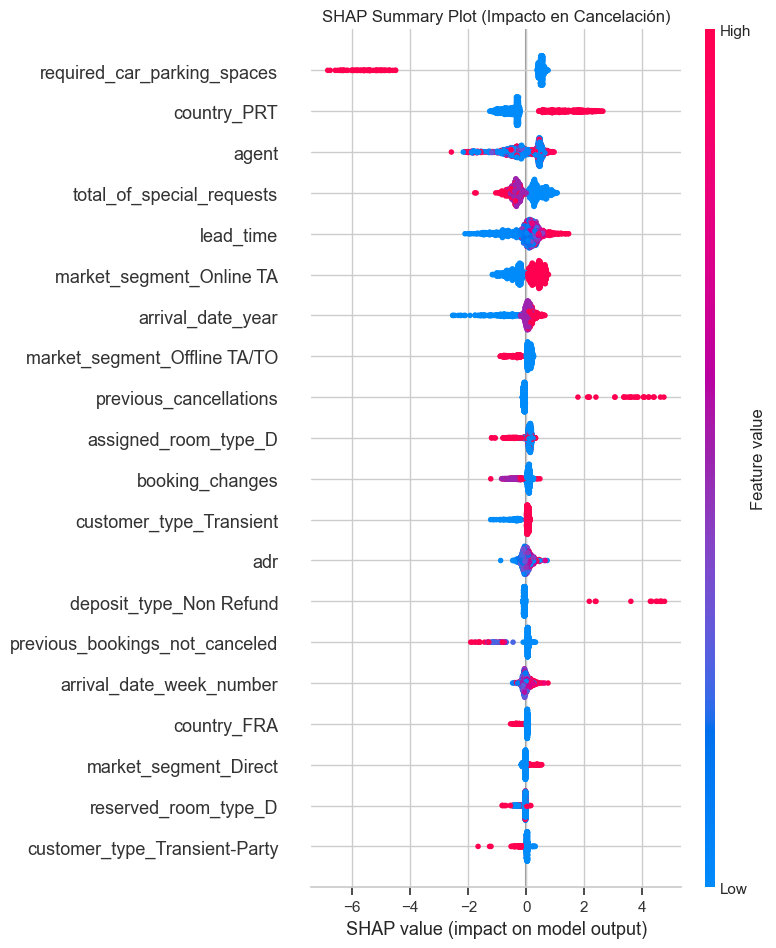

In [18]:
import shap

# Inicializar JS para visualizaciones
shap.initjs()

# Crear el explainer para LightGBM
# Usamos TreeExplainer ya que LightGBM es un modelo basado en árboles
explainer = shap.TreeExplainer(model)

# Calculamos los valores SHAP para una muestra del test set (por eficiencia)
# Tomamos 1000 muestras aleatorias
X_test_sample = X_test.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# En clasificación binaria, shap_values puede ser una lista de arrays (uno por clase)
# o un solo array. LightGBM suele devolver una lista para binary [class0, class1].
# Nos interesa la clase 1 (cancelación).
if isinstance(shap_values, list):
    shap_values_target = shap_values[1]
else:
    shap_values_target = shap_values

# Summary Plot
plt.figure()
shap.summary_plot(shap_values_target, X_test_sample, show=False)
plt.title("SHAP Summary Plot (Impacto en Cancelación)")
plt.show()